In [9]:
import tensorflow as tf
print("Kullanılabilir GPU Sayısı: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import os
import time

Kullanılabilir GPU Sayısı:  1


In [10]:
TRAIN_DIR = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\data\\prepared-data\\train"  
VAL_DIR = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\data\\prepared-data\\val"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8 # Kvasir-v2 için 8 sınıf var
EPOCHS = 35 # Denemeler için sonrasında artırılabilir
MODEL_SAVE_PATH = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\models\\" # Modellerin kaydedileceği yer

# Klasörün var olduğundan emin ol
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [11]:
# 'categorical' kullanıyoruz çünkü 8 sınıfımız var
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_dataset.class_names
print("Sınıflar:", class_names)

# Performans için veri setlerini önbelleğe al
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 5592 files belonging to 8 classes.
Found 1600 files belonging to 8 classes.
Sınıflar: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [12]:
def get_base_model():
    # EfficientNetV2B0, ölçeklendirmeyi kendi içinde yapar
    return applications.EfficientNetV2B0(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')

def get_preprocessing_pipeline():
    # Bu model ön işlemeyi (scaling) kendi içinde yapar.
    # Bu yüzden sadece bir girdi katmanı verip geçiyoruz.
    return models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3))
    ], name="efficientnet_baseline_pipeline_FIXED")

# Deney adını da güncelledik
experiment_name = "efficientnetv2_b0_baseline_FIXED"

In [13]:
def create_model(base_model_func, preprocessing_pipeline_func, num_classes):
    # Transfer Learning için temel modeli al ve dondur
    base_model = base_model_func()
    base_model.trainable = False
    
    # Ön işleme hattını al
    preprocessing_pipeline = preprocessing_pipeline_func()
    
    # Modeli birleştir
    inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
    x = preprocessing_pipeline(inputs)
    x = base_model(x, training=False) # 'training=False' önemlidir
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

print(f"Deney Başlatılıyor: {experiment_name}")
model = create_model(get_base_model, get_preprocessing_pipeline, NUM_CLASSES)
model.summary()

Deney Başlatılıyor: efficientnetv2_b0_baseline_FIXED
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet_baseline_pipel  (None, 224, 224, 3)      0         
 ine_FIXED (Sequential)                                          
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
      

In [14]:
start_time = time.time()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)
end_time = time.time()
print(f"Eğitim Süresi: {end_time - start_time:.2f} saniye")

Epoch 1/35
175/175 [==============================] - 13s 54ms/step - loss: 0.8357 - accuracy: 0.7010 - val_loss: 0.4636 - val_accuracy: 0.8369
Epoch 2/35
175/175 [==============================] - 8s 48ms/step - loss: 0.4363 - accuracy: 0.8439 - val_loss: 0.3702 - val_accuracy: 0.8619
Epoch 3/35
175/175 [==============================] - 8s 47ms/step - loss: 0.3720 - accuracy: 0.8612 - val_loss: 0.3321 - val_accuracy: 0.8731
Epoch 4/35
175/175 [==============================] - 8s 47ms/step - loss: 0.3312 - accuracy: 0.8721 - val_loss: 0.3158 - val_accuracy: 0.8769
Epoch 5/35
175/175 [==============================] - 8s 47ms/step - loss: 0.3107 - accuracy: 0.8848 - val_loss: 0.3042 - val_accuracy: 0.8844
Epoch 6/35
175/175 [==============================] - 8s 47ms/step - loss: 0.2926 - accuracy: 0.8884 - val_loss: 0.2941 - val_accuracy: 0.8856
Epoch 7/35
175/175 [==============================] - 8s 47ms/step - loss: 0.2812 - accuracy: 0.8929 - val_loss: 0.2839 - val_accuracy: 0.891

In [15]:
model_filename = os.path.join(MODEL_SAVE_PATH, f"{experiment_name}.h5")
model.save(model_filename)
print(f"Model başarıyla kaydedildi: {model_filename}")

Model başarıyla kaydedildi: C:\Users\ofaru\Desktop\GitHub\Gastroenterology-CNN-Comparison\models\efficientnetv2_b0_baseline_FIXED.h5


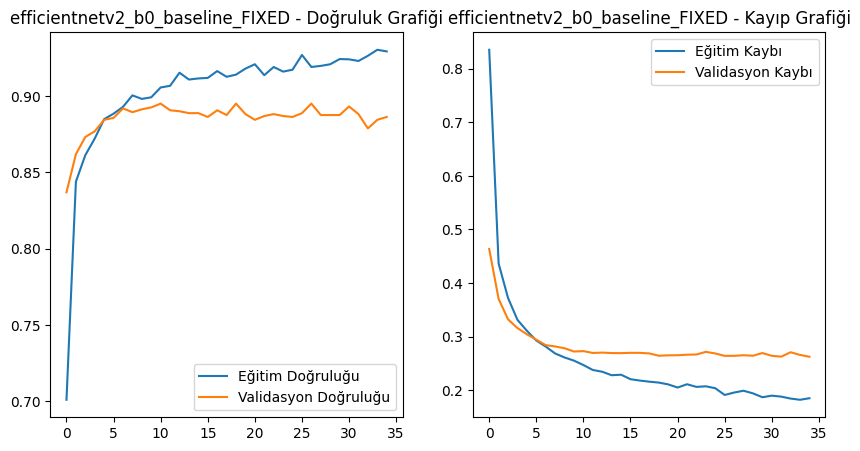

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Validasyon Doğruluğu')
plt.legend(loc='lower right')
plt.title(f'{experiment_name} - Doğruluk Grafiği')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Validasyon Kaybı')
plt.legend(loc='upper right')
plt.title(f'{experiment_name} - Kayıp Grafiği')
plt.show()